# 5. Generating Realistic Stimuli with FilterNet

In the previous chapters we created biophysically detailed and point-neuron toy models of the Mouse VISp L4 and stimulated them with LGN-like cells with firing rates using a Poisson distribution. This can provide insightful information about our model. But if we want to build a model that can more accurately mimic the behavior of a mouse visual system we will need to start providing more realistic stimuli - stimuli that would be generated by the retina and thalamus.

This is where the FilterNet module of BMTK comes into play. With FilterNet we can project different type of visual stimuli onto a receptive field of "filter" type neurons. Using a linear-nonlinear Poisson model, FilterNet will generate spike-trains for each neuron based on the temporal and spatial dynamics of the visual stimuli. For modeling the LGN receptive fields, we will use 2D Gaussians for simplicity. To gain a more in depth intuition about the spatial and temporal filters, see [Modeling the visual field (with FilterNet): Units](https://alleninstitute.github.io/bmtk/tutorial_filter_models.html#Units).

![](../images/bmtk_lnp.png)

For this tutorial we will use FilterNet to generate LGN response spike trains to different types of visual stimuli, then use the feedforward connections from our previous model to deliver these inputs to our PointNet (or BioNet) L4 network.

![](../images/filternet_to_pointnet_workflow.png)

After that we will build a more advanced model of the LGN which will come in handy later as we try to recreate the full mouse V1 model.


## Importing the PointNet Model

The first step is to copy the previous chapter's LGN and L4 model files, then create the configuration files and scripts for running a FilterNet simulation. As before we have already taken care of this for you. However if you wanted to do so from scratch:

```bash
$ cp -r ../Ch4_pointnet/network/* network/
$ cp -r ../Ch4_pointnet/components/* components/

# Create configs and run scripts for FilterNet
$ $ python -m bmtk.utils.sim_setup                             \
           --config-file config.simulation_filternet.json      \
           --network network                                   \
           --tstop 3000.0                                      \ 
           filternet .
```

#### Setting the stimuli

Now we must choose the stimuli, which we can do using the "**inputs**" section of _config.simulation_filternet.json_. Besides regular movies, there are a number of built-in stimuli type that FilterNet will create for us. We'll start with a <ins>Full-Field Flash</ins> stimulation.


```json
 {
   "inputs": {
     "full_field_flash": {
       "input_type": "movie",
       "module": "full_field_flash",
       "row_size": 120,
       "col_size: 240,
       "t_on": 1000.0,
       "t_off": 2000.0,
       "max_intensity": 3.0,
       "frame_rate": 1000.0
     }
   }
 }
```

* We set **input_type** to 'movie' and **module** to "full_field_flash" which will direct BMTK to the type of stimuli to create.

* It's important that the **row_size** and **col_size** match our visual space, which we created as a 120x240 plane. The LGN network was created with the same coordinates so we can map directly between LGN position and visual space.

* Next we tell BMTK to turn on the stimuli at 1000 ms (**t_on**) and off at 2000 ms (**t_off**). The intensity of the flash is set by **max_intensity** which is positive for white, negative for black, and default 0 for a grey screen.


We also want to modify the "**outputs**" sections so that the spike-trains generated by FilterNet are saved to the _inputs/_ directory (since indeed we will be using these spikes as inputs for our L4 simulation).

```json
 {
   "output": {
     "output_dir": "./inputs",
     "log_file": "log.txt"
     "rates_h5": "rates.flash.h5",
     "spikes_file_csv": "spikes.flash.csv",
     "spikes_file": "spikes.flash.h5"
   }
 }
```


#### Running FilterNet

We can run filternet in the command line terminal using the _run_filternet.py_ script:

```python
$ python run_filternet.py config.simulation_filternet.json
```

If we were dealing with a very large network we can even run it on multiple cores:
```python
$ mpirun -np <N> python run_filternet.py config.simulation_filternet.json
```

or we can run it in the notebook:

In [1]:
from bmtk.simulator import filternet

config = filternet.Config.from_json('config.simulation_filternet.flash.json')
config.build_env()

net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

2022-07-07 15:13:03,439 [WARNING] Directory ./inputs already exists.
2022-07-07 15:13:03,440 [INFO] Created log file
2022-07-07 15:13:05,582 [INFO] Building cells.
2022-07-07 15:13:08,066 [INFO] Evaluating rates.
2022-07-07 15:13:19,983 [INFO] Done.


We can plot the results of providing a full-field flash to our LGN cells:

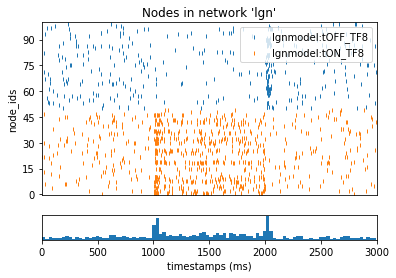

In [2]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.simulation_filternet.flash.json', group_by='model_template')

Remember that when we built our LGN cells we used two different types of cell-models: transient ON cells (*tON_TF8*) and transient OFF cells (*tOFF_TF8*). 

```python
lgn = NetworkBuilder('lgn')
x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tON_TF8',
    dynamics_params='tON_TF8.json',
    ei_type='e'
)
x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tOFF_TF8',
    dynamics_params='tOFF_TF8.json',
    ei_type='e'
)
```

From the results of our full-field flash we can clearly see how the two different types of cells react to changes in the stimulus.

### Rerunning the L4 model with full-field flash stimuli.


Now that we have a new set of stimuli for our LGN cells, rather than the simple Poisson spike trains we were previously using, it is a trivial matter to substitute in our full-field flash results. 

All we have to do is open *config.simulation_pointnet.py* and modify the "**inputs**" section so it is now using the new *spikes.flash.h5* file we created.


Then run PointNet as like before and plot the results.

In [3]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.flash.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

[INFO] [2022.7.7 15:13:26 /home/ping/bmtk_proj/nest-simulator-2.20.1/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.7.7 15:13:26 /home/ping/bmtk_proj/nest-simulator-2.20.1/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.1
 Built: Jan  1 2022 23:06:15

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2022-07-07 15:13:26,949 [INFO] Created log file
2022-07-07 15:13:26,964 [INFO] Batch processing nodes for l4/0.
2022-07-07 15:13:26,965 [INFO] Batch processing nodes for l4/1.
2022-07-07 15:13:26,976 [INFO] Batch processing nodes for lgn/0.
2022-07-07 15:13:27,002 [INFO] Setting up output directory
2022-07-07 15:13:27,003 [INFO] Building cells.
2022-07-0

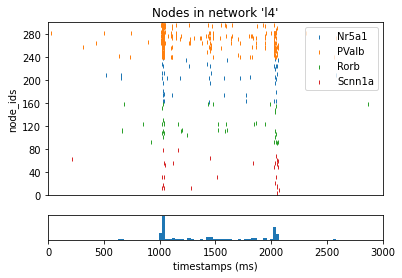

In [4]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.simulation_pointnet.flash.json', group_by='model_name', show=False)

### Running FilterNet with Brain-Observatory Stimuli

Besides full-field flashes, FilterNet can automatically generate all kinds of stimuli like [Drifting Gratings](https://alleninstitute.github.io/bmtk/filternet.html#grating) and [Looming Stimuli](https://alleninstitute.github.io/bmtk/filternet.html#looming).

__[TODO: Show both types of stimuli and results of running FilterNet]__


But for even more advanced stimuli we may want to create our own movie. Currently FilterNet can use any numpy matrix file (.npy or npz) the user creates. When creating movie files we recommend the following rules:

* The array should be of dimensions TxRxC (time x row x column) - where RxC is the array size of the visual space, and each slice in time represents a different frame. There are options in FilterNet config to resize RxC to fit the field, but this can lead to unpredictable distortion.


* FilterNet works best with a Frame Rate of 1000Hz.


* Movies should be grey-scaled, with floating-point pixel values between \[-1, +1\], but if the movie uses \[0, 255\] FilterNet will convert it automatically.


#### Allen Brain-Observatory

The [Allen Brain Observatory](https://observatory.brain-map.org/visualcoding/) provides a large and robust dataset of cell responses to different visual stimuli - and a good set of in-vivo data for which we can customize and compare our models to. Among the stimuli used in the Allen Brain Observatory includes static images of [natural scenes](https://observatory.brain-map.org/visualcoding/stimulus/natural_scenes) and [movies](https://observatory.brain-map.org/visualcoding/stimulus/natural_movies). We will now show how we can recreate these stimuli and use it in our own model.

Starting with natural scene images, we'll need to use the AllenSDK to download the 118 images then use them to create a movie. The following functions will help us:

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image

from allensdk.core.brain_observatory_cache import BrainObservatoryCache


def get_natural_scenes(output_dir='bob_images'):
    """Fetches the 118 Brain Obs natural scene images from the data, saves them in npy format"""
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
    data_set = boc.get_ophys_experiment_data(501498760)
    scenes = data_set.get_stimulus_template('natural_scenes')

    for i in range(0, len(scenes)):
        scene = scenes[i]
        base_name = os.path.join(output_dir, 'scene.{:03d}.gray_{}x{}'.format(i, scene.shape[0], scene.shape[1]))
        plt.imsave('{}.png'.format(base_name), scene, cmap='gray')
        # np.save('{}.npy'.format(base_name), scene)


def create_movie_natural_scenes(images, movie_path, image_dur=250.0,  gs_dur=500.0, res_row=120, res_col=240, fps=1000.0):
    """Will create a movie of the given images - with a pre- and post- grey-screen of the same duration"""
    frames_per_image = int((image_dur/1000.0)*fps)
    frames_per_gs = int(int((gs_dur/1000.0)*fps))
    n_frames = frames_per_gs + len(images)*frames_per_image + frames_per_gs

    output_mat = np.zeros((n_frames, res_row, res_col), dtype=float)
    c_frame = frames_per_gs
    for img_path in images:
        pic = Image.open(img_path).convert('L')
        pic = pic.resize((res_col, res_row))
        pic_data = np.asarray(pic)
        pic_data = pic_data.astype(dtype=float) * 2.0 / 255.0 - 1.0
        output_mat[c_frame:(c_frame + frames_per_image), :, :] = pic_data

        c_frame += frames_per_image

    np.save(movie_path, output_mat)


def show_movie(movie_file, frames):
    """Helps visualize the movie"""
    movie_array = np.load(movie_file)
    fig, ax = plt.subplots(1, len(frames), figsize=(40, 5*len(frames)))

    for i, frame in enumerate(frames):
        ax[i].imshow(movie_array[frame, :, :], cmap='gray', vmin=-1.0, vmax=1.0)
        # ax[i].set_xticks([])
        ax[i].set_xticks([0])
        ax[i].set_xticklabels([frame])

        ax[i].set_yticks([])

    ax[0].set_xlabel('frame #', horizontalalignment='right')
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

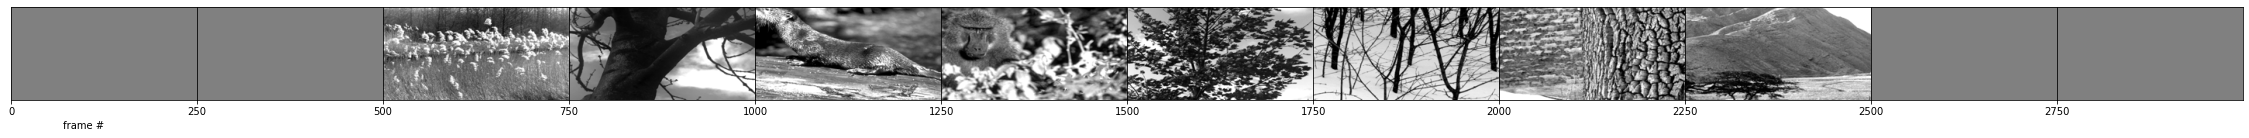

In [6]:
if not os.path.exists('bob_images'):
    # Only need to download bob_images once
    get_natural_scenes()

# Fetch 8 images, create a movie of images including beginning and ending grey-screen
images = glob('bob_images/scene*.png')
images = np.random.choice(images, size=8, replace=False)
create_movie_natural_scenes(images, movie_path='movies/ns_movie.8images.npy')
show_movie(movie_file='movies/ns_movie.8images.npy', frames=range(0, 3000, 250))

Now that we have our "natural scene images" movie, we can update the "**input**" and "**output**" section of the FilterNet simulation config as such:

```json
  {
    "inputs": {
      "input_type": "movie",
      "module": "movie",
      "data_file": "./movies/ns_movie.8images.npy",
      "frame_rate": 1000.0        
    },
      
    "output": {
      "output_dir": "./inputs",
      "log_file": "log.txt",
      "rates_h5": "rates.ns_movie.h5",
      "spikes_file_csv": "spikes.ns_movie.csv",
      "spikes_file": "spikes.ns_movie.h5"
    }
  }
    
```

And run FilterNet as we have been doing.

In [7]:
from bmtk.simulator import filternet

config = filternet.Config.from_json('config.simulation_filternet.ns_movie.json')
config.build_env()

net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

2022-07-07 15:13:54,739 [WARNING] Directory ./inputs already exists.
2022-07-07 15:13:54,741 [INFO] Created log file
2022-07-07 15:13:55,089 [INFO] Building cells.
2022-07-07 15:13:57,676 [INFO] Evaluating rates.
2022-07-07 15:14:16,240 [INFO] Done.


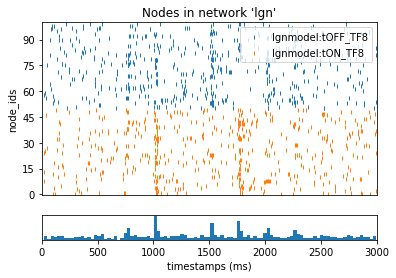

In [8]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.simulation_filternet.ns_movie.json', group_by='model_template')

To run PointNet with the new FilterNet output just edit the _config.simulation.json_ 's "**input**" section so the name of the spike-trains files is now pointing to _inputs/spikes.natural_scenes.h5_.


In [9]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.ns_movie.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2022-07-07 15:14:26,230 [INFO] Created log file
2022-07-07 15:14:26,243 [INFO] Batch processing nodes for l4/0.
2022-07-07 15:14:26,243 [INFO] Batch processing nodes for l4/1.
2022-07-07 15:14:26,254 [INFO] Batch processing nodes for lgn/0.
2022-07-07 15:14:26,304 [INFO] Setting up output directory
2022-07-07 15:14:26,305 [INFO] Building cells.
2022-07-07 15:14:26,312 [INFO] Building recurrent connections
2022-07-07 15:14:26,351 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-07 15:14:26,395 [INFO] Network created.
2022-07-07 15:14:26,522 [INFO] Starting Simulation
2022-07-07 15:14:37,969 [INFO] Simulation finished, finalizing results.
2022-07-07 15:14:40,301 [INFO] Done.


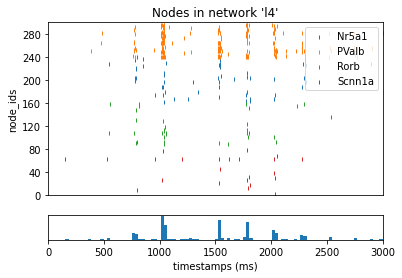

In [10]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.simulation_pointnet.ns_movie.json', group_by='model_name', show=False)

The Allen Brain-Observatory stimulus also includes actual movies, three clips taken from the 1958 Orson Welles film "Touch of Evil". Two of the clips, "natural_movie_one" and "natural_movie_two", are 30 second clips while "natural_movie_three" will run for 120 seconds.

The following function will help download the movies, convert them to 120x240 resolution, upscale the frame rate from 30 fps to 1000 fps, and save the npy files into the _movies/_ directory.

In [11]:
def get_touchofevil_movies(output_dir='movies', res_row=120, res_col=240, fps=1000):
    frame_conv = int(np.floor(fps/30.0))
    def convert_movie(name, movie):
        t, x, y = movie.shape
        n_frames = frame_conv * t
        movie_updated = np.zeros((n_frames, res_row, res_col), dtype=float)
        c_frame = 0
        for frame in range(t):
            # Resize resolution
            img = Image.fromarray(movie[frame, :, :], mode='L')
            img = img.resize((res_col, res_row))
            img_data = np.asarray(img)
            img_data = img_data.astype(dtype=float) * 2.0 / 255.0 -1.0

            # Upscale frame rate
            movie_updated[c_frame:(c_frame + frame_conv), :, :] = img_data
            c_frame += frame_conv

        np.save('{}/{}.{}ms.{}x{}.npy'.format(output_dir, name, c_frame, res_row, res_col), movie_updated)

    boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
    data_set = boc.get_ophys_experiment_data(506248008)
    movie = data_set.get_stimulus_template('natural_movie_one')
    convert_movie('natural_movie_one', movie)

    movie = data_set.get_stimulus_template('natural_movie_two')
    convert_movie('natural_movie_two', movie)

In [12]:
get_touchofevil_movies()

If you want to run the LGN and L4 simulation with these movies remember to do the following:

1. In the FilterNet simulation config update the **input** movie path to the correct *npy file name.

2. Update FilterNet's "**output**" 'spikes_file' to a more appropiate name. And make sure to update PointNet's **input** section accordingly.

3. For Both FilterNet and PointNet update the "**run**" sections 'tstop' to 30,000 (or 120,000 for natural_movie_three) to simulate the entire clip.

## (OPTIONAL) Deep Dive into LGN cell subunit types

Might be a good time to go over the different LGN subunits types